# Genetic Algorithms With Pareto Fronts


<img src="https://upload.wikimedia.org/wikipedia/commons/f/fd/Knapsack.svg" width=250>

This notebook may be used in Google Colab. To access press this button:    
<a href="https://colab.research.google.com/github/elzurdo/multi_objective_optimisation/blob/master/02_knapsack_2D_stochastic.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="First: Open In Colab"/></a>

Here you will learn about implementing Pareto Optimisation with a Genetic Algorithm.  

This notebook follows the previous one in which we learned about the fundamentals of Pareto Fronts, where we examined the Knapsack problem in an exhaustive search space. Here we will learn to apply in a search space that is computationally large.  

Most real life situations involve search spaces that are intractable, meaning that we might never have enough computational power to access to all the feasible solutions (baring from introduction of quantum computing). One approach is to search in a stochastic (random) manner. Not completely random, though, we would like to both exploit what we know works as well as explore new regions in the Decision and Objective spaces.  

To this end we will define and use the Genetic Algorithms as our stochastic search mechanism, where Pareto Fronts are used as its *Selection Function* as detailed below. 

**Main Take Aways**.   
* In a stochastic search no two Pareto front are the same -- but two Pareto fronts are always better than one! You will learn that Pareto Fronts will vary, but one can benifit from joining set of solutions together to get better results.  
* The basics of Genetic Algorithms with an emphasis on Pareto Fronts as the selection function.   
* You will see how the Genetic Algorithm learns by tracking the evolution of the Pareto Front.



**The Knapsack Problem**   
In this challenge you will fill virtual knapsacks with packages that have monetary value and weight.   
The objective is to minimise the final weight of the knapsack and maximise the total monetary value of its contents.    
(You will also be able to change the objectives from min-max to the other options: max-max and min-min, max-min.)

**Recommended Notebook Usage**

We first recommend you be familiar with the fundamentals of Pareto fronts as introduced in the previous notebook. You will notice that some conventions used there are applied here, too.

Do each of the following steps at a time and answer the summary questions to ensure that the main lessons have been understood. 

<ul>
      
<details>
        <summary>Setup, Decision Space and Objective Space</summary> 
            The data generation of packages and knapsacks is the same as before with the exception that we will look at a subset of all possible knapsacks, due to the fact that we will examine much large Decision Spaces. The Objective Space is the same. 
</details>
    
<details>
        <summary>TBD</summary> 
            TBD  
</details>
    
</ul>
    
There is no need to understand every line of Python, especially in the first run! Reading the cell headers is sufficient to understand what a cell does.  It is more important to understand the text in the Markdown cells and the visuals created.  

We recommend doing the first run until the [Summary](#Summary) section as is. 
Afterwhich we recommend that you explore different types of results by modfiying the variables flagged with ***CHANGE ME!***. We list in the [Summary](#Summary) section suggested actions to take, but feel free to be creative!


<img src="https://global.pydata.org/assets/images/logo.png" width="300">  

**One final note to PyData Global participants**  

Don't worry if you don't manage to to go through everything in depth during the allocated time. You will be able to access to this notebook later.

In [148]:
import numpy as np

import matplotlib.pyplot as plt

In [149]:
SMALL_SIZE = 12
MEDIUM_SIZE = 16
BIGGER_SIZE = 20

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('axes', titlesize=BIGGER_SIZE)  # fontsize of the figure title

plt.rcParams['figure.figsize'] = 12, 8

# Packages 

Let's create some data!

<img src="https://uk.packsize.com/wp-content/uploads/sites/11/2015/05/wp-boxes.jpg" width=300>

Same as in the previous tutorial, here we create packages by defining for each its weight and monetary value according to a distribution.   

Parameters of interest:  
* `N_PACKAGES` - the total number packages to choose from.  
* `value_distribution_mode` - indicates the relationship between the package weight and monetary value.   
The weights are randomly distributed where: 
    * `value_distribution_mode=random` - monetary value distribution also random
    *  `value_distribution_mode=squared` - monetary value is squared that of the weights (up to some noise quantified by `noise_factor`).  
    
This will results in 
* `packages` a dictionary containing information of the `N_PACKAGES` packages.
 It has the form `{key: package}`, where each package have the form `{'weight': weight, 'value': value}`

In [150]:
seed = 3141592653 # CHANGE ME! to get a different distribution

N_PACKAGES = 20   # CHANGE ME! the total number of packages to choose from

WEIGHT_MEAN = 0.1 # CHANGE ME! the mean of the weight distribution
WEIGHT_SD = 10    # CHANGE ME! the standard deviation of the weight distribution

VALUE_MEAN = 0.1  # CHANGE ME! when value_distribution_mode='random': the mean of the monetary value distribution 
VALUE_SD = 100    # CHANGE ME! when value_distribution_mode='random': the standard deviation of the monetary value distribution 

value_distribution_mode = 'random' # CHANGE ME! options: 'random', 'squared'
noise_factor = 1./2  # CHANGE ME! when value_distribution_mode='squared': the standard deviation of the noise introduced
# ---------------

np.random.seed(seed)

weights = np.abs(np.random.normal(WEIGHT_MEAN, WEIGHT_SD, N_PACKAGES))

if 'squared' == value_distribution_mode:
    values =  weights ** 2 
    values += values * np.random.normal(0, noise_factor, len(weights))
    values = np.abs(values)
elif 'random' == value_distribution_mode:
    values = np.abs(np.random.normal(VALUE_MEAN, VALUE_SD, N_PACKAGES))

In [151]:
# packages dictionary
packages = {idx: {'weight': weights[idx], 'value': values[idx]} for idx in range(N_PACKAGES)}

{ipackage: package for ipackage, package in packages.items() if ipackage < 4}

[{'weight': 16.045064716419265, 'value': 122.44920604368212},
 {'weight': 10.257933643337433, 'value': 34.08475741925324},
 {'weight': 7.427142915985984, 'value': 7.3477194585976235},
 {'weight': 16.1061446548582, 'value': 75.21497126311662}]

Text(0.5, 1.0, 'Packages')

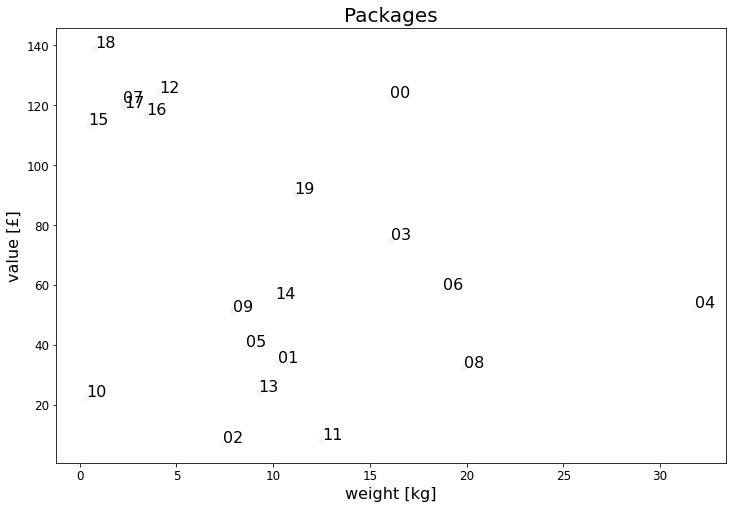

In [152]:
# visualising the package weight-value distribution

plt.scatter([packages[idx_package]['weight'] for idx_package in packages],
            [packages[idx_package]['value'] for idx_package in packages],
            color = 'purple', alpha=0.04
           )

for idx_package, package in packages.items():
    plt.annotate(f'{idx_package:02.0f}', xy=(package['weight'], package['value']), fontsize=MEDIUM_SIZE)
    
plt.xlabel('weight [kg]')
plt.ylabel('value [£]')
plt.title('Packages')

#  Decision and Objective Spaces


## Decision Space Size
There are two parameters of interest that decide how many knapsacks are possible: 
* `N_PACKAGES` which was determined in [Packages](#Packages).
* `N_PACKAGES_PER_KNAPSACK` introduced here determines the number of packages that fit into a knapsack.  


We can easily calculate the number of combinations defined as an unordered arrangement of $k$ objects from a set of $n$, which is called  *$n$ choose $k$*.  

which is calculated as:  
$$
_nC_k=\frac{n!}{(n-k)!k!}\equiv {n \choose k}
$$

Here we use     
`k = N_PACKAGES_PER_KNAPSACK`  
`n = N_PACKAGES`,  
with assumptions for simplicity:  
* A package can appear only once in a a knapsack.  
* The order of a package assigned to a knapsack does not matter. 

**Note**  
You do not need to understand the equation above.  
Below you are provided with a calculator that executes this equation using the `math.factorial` function   



In [153]:
from math import factorial

In [154]:
def pretty_int(x):
    if x > 1.e6:
        return f'{int(x):0.1e}'
    else:
        return f'{int(x):,}'

N_PACKAGES_PER_KNAPSACK = 10
# -----------
    
n = N_PACKAGES
k = N_PACKAGES_PER_KNAPSACK

n_combinations = factorial(n)//factorial(k)//factorial(n-k)

f'There are {pretty_int(n_combinations)} combinations of {n} choose {k}.'

'There are 184,756 combinations of 20 choose 10.'

## Knapsacks

Here we will create the `n_knapsacks` knapsacks using the `create_knapsacks` function which does two functions: 
* Decision Space: assigns packages to the knapsack  
* Objective Space: calculates that knapsack weight and the sum of the monetary value of its contents using the `knapsack_objective` function.


<img src="https://www.chatelaine.com/wp-content/uploads/2019/07/5-most-popular-backpacks-feature.jpg" width=500>


Each knapsack contains one feasible combination of `N_PACKAGES_PER_KNAPSACK` packages (of the total `N_PACKAGES` packages). 

* The `knapsack_objective` function determines the knapsack objective value (`weight`, `value`) by summing those of all its `packages`.  
* The `create_knapsacks` function creates `n_knapsacks`. 

In [155]:
# the properties of the knapsack that we want to optimise

objectives = ['weight', 'value']

In [156]:
# Decision Space to the Objective Space mapping: calculates for each knapsack its `objective` value

def knapsack_objective(knapsack, objective, packages):
    knapsack[objective] = np.sum([packages[idx_package][objective] for idx_package in knapsack['packages']])

In [157]:
# creates a dictionary of `n_knapsacks` knapsacks

def create_knapsacks(n_knapsacks=1000, seed=0, n_packages=N_PACKAGES, n_packages_per_knapsack=N_PACKAGES_PER_KNAPSACK):
    knapsacks = {}
    for idx_knapsack in range(n_knapsacks):
        if seed:
            np.random.seed(idx_knapsack + seed)
        this_idxs_packages = np.random.choice(range(n_packages), n_packages_per_knapsack, replace=False)

        knapsacks[idx_knapsack] = {}
        knapsacks[idx_knapsack]['packages']= this_idxs_packages

        for objective in objectives:
            knapsack_objective(knapsacks[idx_knapsack], objective, packages)
            
    return knapsacks

To explore the stochastic nature of the problem we will create multiple dictionaries of knapsacks which we will call *instances*.   

In [158]:
# creating `n_instances` dictionaries of `n_knapsacks` knapsacks

n_instances = 4
n_knapsacks = 1000

knapsacks_instances = {}
for idx in range(n_instances):
    knapsacks_instances[idx] = create_knapsacks(n_knapsacks, seed=idx * 100000)


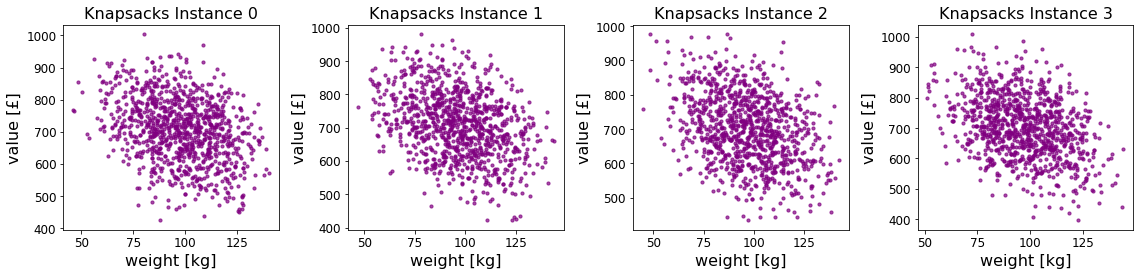

In [159]:
nplots = n_instances
ncols = 4
nrows = nplots // ncols + np.sum(nplots % ncols != 0)

plt.figure(figsize=(4 * ncols, 4 * nrows))

for idx_instance in knapsacks_instances:
    plt.subplot(nrows, ncols, idx_instance + 1)
    
    plt.scatter([knapsacks['weight'] for _, knapsacks in knapsacks_instances[idx_instance].items()],
                [knapsacks['value'] for _, knapsacks in knapsacks_instances[idx_instance].items()],
                s=10, alpha=0.7, color='purple')

    plt.xlabel('weight [kg]')
    plt.ylabel('value [£]')
    plt.title(f'Knapsacks Instance {idx_instance}', fontsize=MEDIUM_SIZE)
plt.tight_layout()

In the above we see that even though the distributions in Objective Space (weight, value) trace similar trends, each has its own distinct features that will impact the Pareto Front.  

Can you identify by eye the Pareto Front for each instance?    
(Beforehand you will need define the Optimisation Objectives! E.g, minimising weight and maximising value.)

# Optimisation Objective

In the knapsack problem we want to optimise for two objectives:    
* ↓ minimise the knapsack weight 
* ↑ maximise the moentary values of the packages in the knapsack
 
 
**Note**    
The default setting here is ↓↑, but feel free to explore the other combinations: ↓↓, ↑↓ or ↑↑. (See the ***CHANGE ME!*** for `objective_mode`).    

In [ ]:
from operator import lt as less_than, gt as greater_than
from operator import (truediv as div, mul)

In [ ]:
# Objective Space declaration

# CHANGE ME!
objective_mode, heuristic, soh_unit = {'weight': 'min', 'value': 'max'}, 'value/weight', '£/kg'
#objective_mode, heuristic, soh_unit = {'weight': 'min', 'value': 'min'}, '1/value/weight', '1/£/kg'
#objective_mode, heuristic, soh_unit = {'weight': 'max', 'value': 'max'}, 'value*weight',  '£*kg'
#objective_mode, heuristic, soh_unit = {'weight': 'max', 'value': 'min'}, 'weight/value', 'kg/£'

In [ ]:
# These objects are used to calculate the relationships between the knapsacks.

# for Single Objective Optimisation
direction_to_multiplier = {'min': div, 'max': mul}

# for Pareto Optimal selection
mode_to_operator = {'min': less_than, 'max': greater_than}
objective_operator = {key: mode_to_operator[objective_mode[key]] for key in objective_mode.keys()}

# Pareto Front Calculation
`knapsacks_to_pareto_front` is a function with the same algorithm used in the previous notebook, where:  
* input: dictionary of knapsacks
* output: list of indexes of knapsacks that are Pareto optimal

Here we will calculate the Pareto front for each of the instances.

In [162]:
def knapsacks_to_pareto_front(knapsacks):
    objective_values = {}

    for objective in objectives:
        objective_values[objective] = [knapsacks[idx][objective] for idx in knapsacks]
        
    idxs_pareto = []
    
    idx_objects = list(knapsacks.keys())

    for idx in range(len(objective_values[objective])):
        is_pareto = True

        this_weight = objective_values['weight'][idx]
        this_value = objective_values['value'][idx]

        other_weights = np.array(objective_values['weight'][:idx] + objective_values['weight'][idx + 1:])
        other_values = np.array(objective_values['value'][:idx] + objective_values['value'][idx + 1:])

        for jdx in range(len(other_weights)):
            other_dominates = objective_operator['weight'](other_weights[jdx], this_weight) & objective_operator['value'](other_values[jdx], this_value)   

            if other_dominates:
                is_pareto = False
                break

        if is_pareto:
            idxs_pareto.append(idx_objects[idx])
            
    return idxs_pareto

In [163]:
# calculating the pareto front for each instance

pareto_instances = {}
for idx_instance in knapsacks_instances:
    pareto_instances[idx_instance] = knapsacks_to_pareto_front(knapsacks_instances[idx_instance])

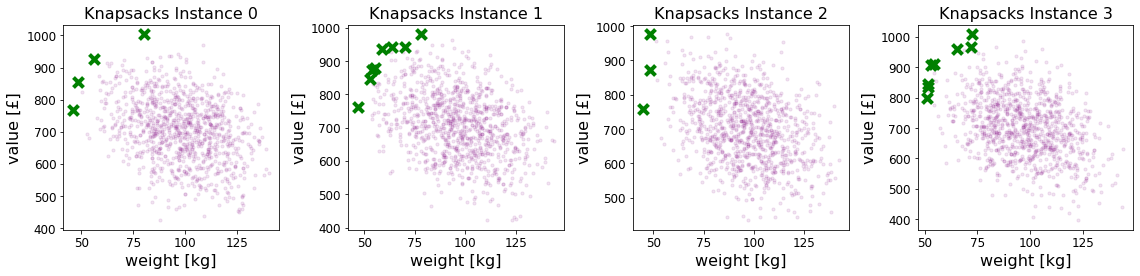

In [164]:
# visualising the knapsack set instances with an emphasis on the Pareto fronts

nplots = n_instances
ncols = 4
nrows = nplots // ncols + np.sum(nplots % ncols != 0)

plt.figure(figsize=(4 * ncols, 4 * nrows))

for idx_instance in knapsacks_instances:
    plt.subplot(nrows, ncols, idx_instance + 1)
    
    plt.scatter([knapsacks['weight'] for _, knapsacks in knapsacks_instances[idx_instance].items()],
                [knapsacks['value'] for _, knapsacks in knapsacks_instances[idx_instance].items()],
                s=10, alpha=0.1, color='purple')
    
    plt.scatter([knapsacks_instances[idx_instance][idx_knapsack]['weight'] for idx_knapsack in pareto_instances[idx_instance]], 
                [knapsacks_instances[idx_instance][idx_knapsack]['value'] for idx_knapsack in pareto_instances[idx_instance]], 
            marker='x', s=100, linewidth=4, color='green', label='Pareto Front')

    plt.xlabel('weight [kg]')
    plt.ylabel('value [£]')
    plt.title(f'Knapsacks Instance {idx_instance}', fontsize=MEDIUM_SIZE)
plt.tight_layout()

Did you manage to correct the Pareto fronts correctly for each instance? 

We clearly see that each instance is a subset of the full space resulting in wildly different Pareto front estimates. 
By estimate we refer to the fact that the Pareto front of each instance isn't the aboslute front for all the possible knapsacks. For this purpose we will later use a Genetic Algorithm to get us as close as possible to the true Pareto front.

To conclude this section we will see that we can combine the four instances to one to obtain a mutual Pareto front which is better than each individual.

In [165]:
# knapsacks_pareto_combined is a set of indexes of the pareto front of the combined set of all instances 

knapsacks_pareto = {}
instance_pareto_details = {}
for idx_instance in knapsacks_instances:
    for idx_knapsack in pareto_instances[idx_instance]:
        idx_pareto = f'{idx_instance}-{idx_knapsack}'
        knapsacks_pareto[idx_pareto] = knapsacks_instances[idx_instance][idx_knapsack]
        instance_pareto_details[idx_pareto] = idx_instance


knapsacks_pareto_combined = knapsacks_to_pareto_front(knapsacks_pareto)

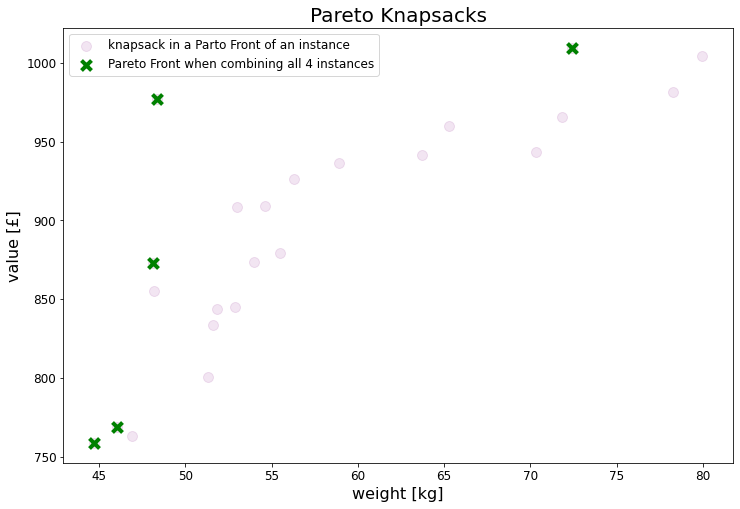

In [168]:
# visualising each instance pareto front (light Xs) and the combined pareto front (thick Xs)

plt.scatter([knapsacks['weight'] for _, knapsacks in knapsacks_pareto.items()],
            [knapsacks['value'] for _, knapsacks in knapsacks_pareto.items()],
            marker='x', s=100, alpha=0.7, color='lightgreen', label='knapsack in a Parto Front of an instance')

plt.scatter([knapsacks_pareto[idx_knapsack]['weight'] for idx_knapsack in knapsacks_pareto_combined], 
            [knapsacks_pareto[idx_knapsack]['value'] for idx_knapsack in knapsacks_pareto_combined], 
        marker='x', s=100, linewidth=4, color='green', label=f'Pareto Front when combining all {n_instances} instances')

for idx_knapsack in knapsacks_pareto_combined:
    plt.annotate(instance_pareto_details[idx_knapsack], [knapsacks_pareto[idx_knapsack]['weight'] + 0.5, knapsacks_pareto[idx_knapsack]['value']], fontsize=20, color='green')

plt.xlabel('weight [kg]')
plt.ylabel('value [£]')
plt.title(f'Pareto Knapsacks')
plt.legend()

This visualisation clearly shows that combining multiple instances to one results in a pareto front that is better than each individuals one.

# Genetic Algorithm Components


<img src="http://aqibsaeed.github.io/img/ga.png" width=500>

This is an illustraction of an example Genetic Algorithm architecture as applied by [Aaqib Saeed](http://aqibsaeed.github.io/2017-08-11-genetic-algorithm-for-optimizing-rnn/). 

We will now explore the various components of the Genetic Algorithm with an emphasis on the role of Pareto Optimisation in the selection function.  

## Definiting Initial Population

In [169]:
N_INITIAL_POPULATION = 20
seed = 3141592653

population = create_knapsacks(N_INITIAL_POPULATION, seed=seed)

## Cross Over Algorithm

One of two transformation functions used in the Genetic Algorithm.  

![crossover](https://user-images.githubusercontent.com/6064016/97842646-dc0c2400-1cdf-11eb-8b59-f0c70274d606.png)

This image uses DNA snippets to illustrate the how the crossover tranformation may be generate two children solutions from two parents.  

In this analogy:  
* A DNA strip corresponds to a knapsack
* The nucleotides (`A`, `C`, `G`, `T`) correspond to the packages (except for the fact that we are using unique packages).

Here we present a few functions 
* `cross_over_2_indvs` - takes in two parents and crosses them over to two children
* `crossover_knapsacks` - takes in all the knapsacks and separates them to pairs of parents and then run them through  `cross_over_2_indvs` which will result in `len(knapsacks)` children. 

### Parents To Children

In [170]:
# Cross over of a pair of parents to a pair of children

def cross_over_2_indvs(ind1, ind2):
    # here we assume:
    # both individuals are non empty lists with the same length
    # a crossover cuts through the middle of the lists
    
    assert len(ind1) == len(ind2)
    
    mutuals = list(set(ind1) & set(ind2))
    
    non_overlap1 = [ind for ind in ind1 if ind not in mutuals]
    non_overlap2 = [ind for ind in ind2 if ind not in mutuals]
    
    ind1_ = non_overlap1.copy()
    ind2_ = non_overlap2.copy()
    
    n_ = len(ind1_)
    
    ind1_[n_//2:] = non_overlap2[n_//2:]
    ind2_[n_//2:] = non_overlap1[n_//2:]
    
    ind1_ += mutuals
    ind2_ += mutuals
    
    return ind1_, ind2_

In [171]:
# dummy example - for this example we are not using packages in knapsacks but rather characters in a list

parent1 =  ['A', 'B', 'C', 'D', 'E']
parent2 = [1, 2, 3, 4, 'C']

print(f'parent 1: {", ".join(parent1)}')
print(f'parent 2: {", ".join(map(str,parent2))}')

child1, child2 = cross_over_2_indvs(parent1, parent2)
print(f'\ncrossed over to\nchild 1: {", ".join(map(str, child1))}\nchild 2: {", ".join(map(str, child2))}')

parent 1: A, B, C, D, E
parent 2: 1, 2, 3, 4, C

crossed over to
child 1: A, B, 3, 4, C
child 2: 1, 2, D, E, C


**A deeper look**

* In this dummy example that the `C` appears in both parents and is passed on to both children (rather than one child having two `C`s and the other none). This corresponds to the `mutuals` term in the `cross_over_2_indvs`. 

* Note that in `cross_over_2_indvs` we do not want the items sorted because that is likely to cause drop in diversity (we will discuss this later).

In [172]:
# working example

idx_indv1 = 0  # change me! index of knapsack
idx_indv2 = 1  # change me! index of knapsack
# -------

parent1 = population[idx_indv1]['packages']
parent2 = population[idx_indv2]['packages']

print(f'parent 1: {", ".join(map(str,parent1))}')
print(f'parent 2: {", ".join(map(str,parent2))}')

child1, child2 = cross_over_2_indvs(parent1, parent2)
print(f'\ncrossed over to\nchild 1: {", ".join(map(str, child1))}\nchild 2: {", ".join(map(str, child2))}')

parent 1: 14, 12, 4, 1, 5, 9, 19, 7, 15, 13
parent 2: 0, 17, 12, 19, 1, 15, 7, 9, 11, 4

crossed over to
child 1: 14, 17, 11, 1, 4, 7, 9, 12, 15, 19
child 2: 0, 5, 13, 1, 4, 7, 9, 12, 15, 19


###  Population

In [177]:
def crossover_knapsacks(population, packages, idx_start=None):
    n_population = len(population)
    
    idxs_parents = list(population.keys())
    
    idxs_parent2 = idxs_parents[1::2]
    idxs_parent1 = idxs_parents[::2][:len(idxs_parent2)]
    
    children = {}
    
    if idx_start is None:
        idx_child_counter = np.max(idxs_parents) # TODO: thie does not generalise well since indviduals will be dropped
    else:
        idx_child_counter = idx_start
        
    for idx_parent1, idx_parent2 in zip(idxs_parent1, idxs_parent2):
        idx_child_counter += 1
        children[idx_child_counter] = {}
        children[idx_child_counter + 1] = {}
        
        children[idx_child_counter]['packages'], children[idx_child_counter + 1]['packages'] = cross_over_2_indvs(population[idx_parent1]['packages'], population[idx_parent2]['packages'])
        
        idx_child_counter += 1
    
    return children
       
children = crossover_knapsacks(population, packages)

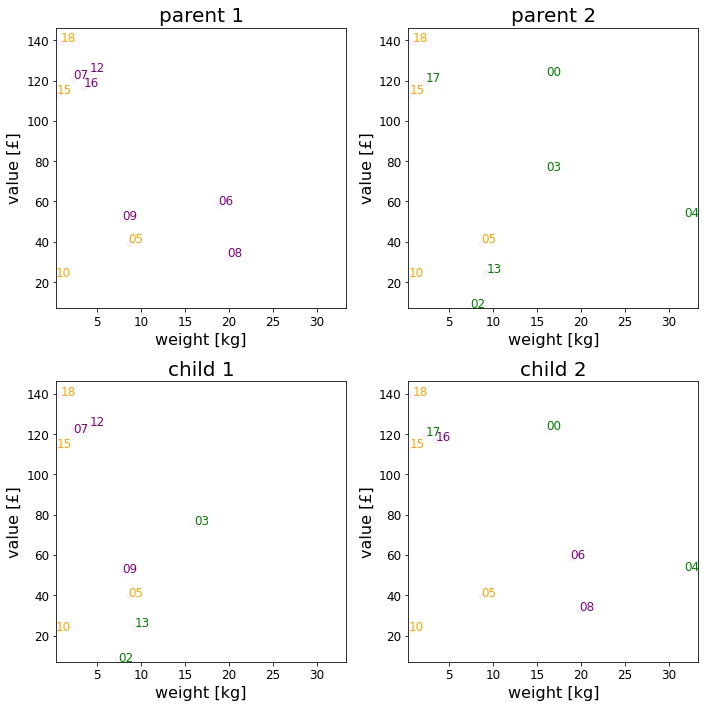

In [178]:
# Examining the Decision Space (packages) of one pair of parents their resulting cross over children.

idx_parent1 = 4
assert idx_parent1 % 2 == 0
knapsacks_plot = {'parent 1': population[idx_parent1], 'parent 2': population[idx_parent1 + 1],
                  'child 1': children[min(list(children.keys())) + idx_parent1],
                  'child 2': children[min(list(children.keys())) + idx_parent1 + 1]
                 }

colors = {'parent 1': 'purple', 'parent 2': 'green', 'both': 'orange'}

# parents_packages = list(set(list(population[0]['packages']) + list(population[1]['packages'])))
# min_weight = np.min([packages[package]['weight'] for package in parents_packages])
# max_weight = np.max([packages[package]['weight'] for package in parents_packages])
# min_value = np.min([packages[package]['value'] for package in parents_packages])
# max_value = np.max([packages[package]['value'] for package in parents_packages])

min_weight = np.min([packages[package]['weight'] for package in packages])
max_weight = np.max([packages[package]['weight'] for package in packages])
min_value = np.min([packages[package]['value'] for package in packages])
max_value = np.max([packages[package]['value'] for package in packages])

ncols = 2
nrows = 2

plt.figure(figsize = (5 * ncols, 5 * nrows))

for ipanel, knapsack_idx in enumerate(knapsacks_plot):
    plt.subplot(nrows, ncols, ipanel + 1)
    
    idx_packages_in_knapsack = knapsacks_plot[knapsack_idx]['packages']
    
    plt.scatter([packages[idx_package]['weight'] for idx_package in idx_packages_in_knapsack],
                [packages[idx_package]['value'] for idx_package in idx_packages_in_knapsack],
                color = 'purple', alpha=0.04
               )
    
    #counts_ = {'both': 0, 'parent 1': 0, 'parent 2': 0}
    for idx_package in idx_packages_in_knapsack: 
        in_parent1 = idx_package in knapsacks_plot['parent 1']['packages']
        in_parent2 = idx_package in knapsacks_plot['parent 2']['packages']
        
        if in_parent1 & in_parent2:
            color = colors['both']
            #counts_['both'] += 1
        elif in_parent1:
            color = colors['parent 1']
            #counts_['parent 1'] += 1
        elif in_parent2:
            color = colors['parent 2']
            #counts_['parent 2'] += 1
        else:
            print('problem!')
            break
        
        plt.annotate(f'{idx_package:02.0f}', xy=(packages[idx_package]['weight'], packages[idx_package]['value']), alpha=1, color=color)
        
    #print(knapsack_idx, counts_)
    
    plt.title(knapsack_idx)
    
    plt.xlim(min_weight * 0.95, max_weight * 1.05)
    plt.ylim(min_value * 0.95, max_value * 1.05)
    plt.xlabel('weight [kg]')
    plt.ylabel('value [£]')
    
plt.tight_layout()

The color coding is as follows: 
* Purple packages are those that originate from only parent 1
* Green packages are those that originate from only parent 2
* Orange packages are those that originate from both parent 1 and 2

We see that both children's packages are crossed over from both parents.

## Mutation

![mutation](https://user-images.githubusercontent.com/6064016/97843727-b54eed00-1ce1-11eb-943f-c725b7fc49ed.png)


Here again we use DNA snippets to illustrate the how the mutation tranformation may be applied to one parent solutions to generate one child.

We will use the function `mutate_knapsack` that takes in an individual knapsack and replaces `n_mutate` packages to created a mutated child knapsack.

In [179]:
def mutate_knapsack(indv_package_idxs, all_package_idxs, n_mutate=1, seed=None):
    remaining_package_idxs = list(set(all_package_idxs) - set(indv_package_idxs))
    
    np.random.seed(seed)
    loc_mutate = np.random.choice(range(len(indv_package_idxs)), n_mutate, replace=False)
    new_package_idxs = np.random.choice(remaining_package_idxs, n_mutate, replace=False)
    
    indv_package_idxs_ = indv_package_idxs.copy()

    for i, loc in enumerate(loc_mutate):
        indv_package_idxs_[loc] = new_package_idxs[i]
    
    return indv_package_idxs_

In [180]:
all_packages = list(packages.keys())
n_packages_mutate = 2    # CHANGE ME!
seed = 2

idx_indv = 0
individual = population[idx_indv]['packages']

print(f'individual original: {", ".join(map(str,individual))}')
individual_mutated = mutate_knapsack(individual, all_packages, n_mutate=n_packages_mutate, seed=seed)
print(f'individual mutated : {", ".join(map(str,individual_mutated))}')
print(f'{len(set(individual) & set(individual_mutated))} packages remain and {len(set(individual) - set(individual_mutated))} were changed')

individual original: 14, 12, 4, 1, 5, 9, 19, 7, 15, 13
individual mutated : 14, 11, 4, 1, 2, 9, 19, 7, 15, 13
8 packages remain and 2 were changed


## Fitness Evaluation

The fitness is determining the values of the objectives (weight, value) for which we will use `knapsack_objective`, same as in the previous notebook.

Here we will apply the algorithm to three of the children generated above (two from crossover, one from mutation) and examine how competitive they are against the original population.

In [307]:
# defining the new generation

population_born = {'child 1': {'packages':child1}, 'child 2': {'packages':child2}, 
                   'individual_mutated': {'packages': individual_mutated}
                  }
population_born

{'child 1': {'packages': [14, 17, 11, 1, 4, 7, 9, 12, 15, 19]},
 'child 2': {'packages': [0, 5, 13, 1, 4, 7, 9, 12, 15, 19]},
 'individual_mutated': {'packages': array([ 1, 10, 19, 12, 16,  4,  9,  5,  2, 11])}}

In [309]:
# evaluating the fitness of the new generation

for _, indv in population_born.items():
    for objective in objectives:
        knapsack_objective(indv, objective, packages)
population_born    

{'child 1': {'packages': [14, 17, 11, 1, 4, 7, 9, 12, 15, 19],
  'weight': 92.8669222089192,
  'value': 770.2954735883773},
 'child 2': {'packages': [0, 5, 13, 1, 4, 7, 9, 12, 15, 19],
  'weight': 101.83251049309172,
  'value': 773.4176186474931},
 'individual_mutated': {'packages': array([ 1, 10, 19, 12, 16,  4,  9,  5,  2, 11]),
  'weight': 97.57538124433513,
  'value': 547.4744168310492}}

Text(0, 0.5, 'value [£]')

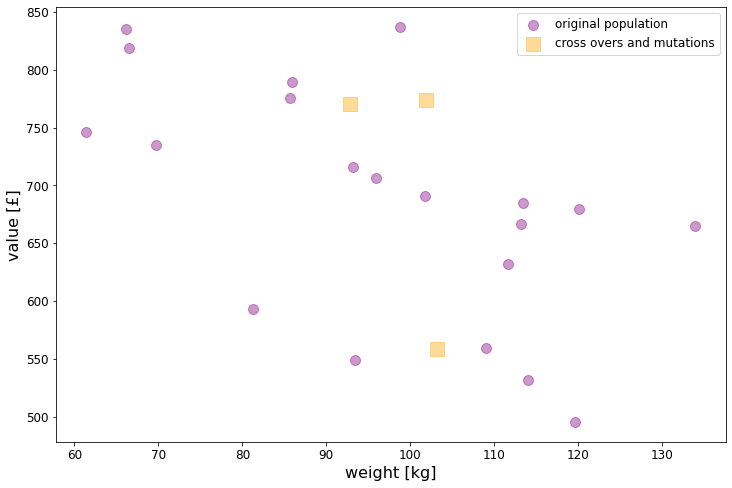

In [183]:
# visualising the population and the new population

plt.scatter([knapsacks['weight'] for _, knapsacks in population.items()],
                [knapsacks['value'] for _, knapsacks in population.items()],
                s=100, alpha=0.4, color='purple', label='original population')

plt.scatter([knapsacks['weight'] for _, knapsacks in population_born.items()],
                [knapsacks['value'] for _, knapsacks in population_born.items()],
                marker='s',s=200, alpha=0.4, color='orange', label='cross overs and mutations')
 

plt.legend()
plt.xlabel('weight [kg]')
plt.ylabel('value [£]')

Results might differ, but there is not reason to be surprised if the results of the children (squares) are not Pareto optimal. That is the stochastic nature of this calculation! At times we will get children that beat their parents, but not always (think of the children of Albert Einstein and Michael Jordan)

## Selection

This is where the Pareto front gets into action!  

Imagine that we have a population competing to continue to the next generation. We need to choose a subset.  
We could naively take only the Pareto front -- but if there aren't many solutions there we will have a drop in diversity.  For this reason we need to choose in advance the number individuals to progress to the next iteration. 

Once this is decided there 



There are various algorithms that use the concept of Pareto optimality.  
Here I describe a fairly simplistic one.  

**Pseudocode**

* input - `n_selection` determines the number of knapsacks to select for the next generation
* 

TBD  
```python
while n_chosen < n_selection:
    ...
```

In [184]:
N_SELECTION = 10
exact_n_selection = False

idxs_knapsacks_selected = []

population_remaining = population.copy()

individuals_selected = []
pareto_fronts = []
while len(individuals_selected) < N_SELECTION:
    these_selected = knapsacks_to_pareto_front(population_remaining)
    
    n_these_selected_and_selected = len(these_selected) + len(individuals_selected)
    if exact_n_selection:
        if n_these_selected_and_selected > N_SELECTION:
            n_these_subset = N_SELECTION - len(individuals_selected)
            these_selected = np.random.choice(these_selected, n_these_subset, replace=False).tolist()

    pareto_fronts.append(these_selected)
    
    individuals_selected = [individual for pareto_front in pareto_fronts for individual in pareto_front]
    
    for individual in these_selected:
        del population_remaining[individual]
        
pareto_fronts    

[[1, 15, 19], [4], [6, 13, 14], [5, 18], [0, 2]]

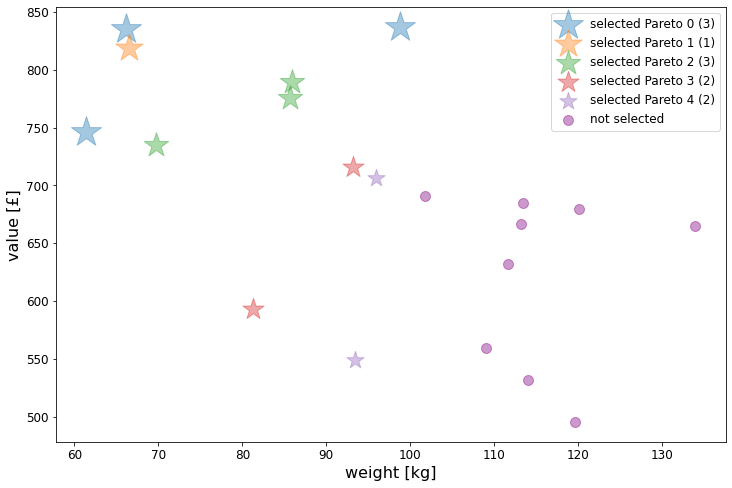

In [185]:
max_size = 1000
for ipareto, pareto_front in enumerate(pareto_fronts):
    size = max_size * (1. - ipareto/6)
    plt.scatter([population[idx_indv]['weight'] for idx_indv in  pareto_front],
                [population[idx_indv]['value'] for idx_indv in  pareto_front],
                marker='*',s=size, alpha=0.4, label=f'selected Pareto {ipareto} ({len(pareto_front)})',)

plt.scatter([knapsacks['weight'] for _, knapsacks in population.items() if _ not in individuals_selected],
                [knapsacks['value'] for _, knapsacks in population.items() if _ not in individuals_selected],
                 s=100, alpha=0.4, color='purple', label='not selected')
    
plt.legend()
plt.xlabel('weight [kg]')
plt.ylabel('value [£]')
pass

# Knacksack Optimisation

Now we'll put all the components together and examine the evolution of the Pareto front estimates of the Knapsack problem!

<img src="https://i.pinimg.com/originals/1a/5c/a8/1a5ca8373a83e8e84f8f268ee3ecf1de.png" width=700>


In [443]:
# -- selection --
PARENTS_COMPETE = True   # True: parents will compete for selection with the children. False: only children compete

# -- mating --
PROB_CROSS_OVER = 0.6    # probability that any parent may craete a child by mating with another parent

# -- mutation --
PROB_MUTATION = 0.4      # probability that any parent may create a child by mutating itself
N_PACKAGES_MUTATE = 2    # number of packages used for the process of mutation


def naive_pareto_selector(population, n_select=20, exact_n_selection = False):
    population_remaining = population.copy()
    
    individuals_selected = []
    pareto_fronts = []
    
    while len(individuals_selected) < n_select:
        these_selected = knapsacks_to_pareto_front(population_remaining)

        n_these_selected_and_selected = len(these_selected) + len(individuals_selected)
        if exact_n_selection:
            if n_these_selected_and_selected > n_select:
                n_these_subset = n_select - len(individuals_selected)
                these_selected = np.random.choice(these_selected, n_these_subset, replace=False).tolist()

        pareto_fronts.append(these_selected)

        individuals_selected = [individual for pareto_front in pareto_fronts for individual in pareto_front]

        for individual in these_selected:
            del population_remaining[individual]
            
    return pareto_fronts,  individuals_selected

def knapsack_to_soh(knapsack):
    return knapsack['value'] / knapsack['weight']

def single_objective_selector(population, n_select=20, objective='value_weight_ratio'):    
    population_sorted = {k: v for k, v in sorted(population.items(), key=lambda indv: indv[1][objective], reverse=True)} 
    
    return {k: population_sorted[k] for k in list(population_sorted.keys())[:n_select]} 

def create_children(idx_indv_start, idxs_parents, population_parents, n_packages_mutate=None):
    idxs_chidren = {}
    
    if n_packages_mutate is None:
        n_packages_mutate = N_PACKAGES_MUTATE
    
    # children replicated
    idxs_chidren['replicated'] = list(np.arange(idx_indv_start, idx_indv_start + len(idxs_parents['replicate'])))
    population_children = {idxs_chidren['replicated'][counter]: population_parents[idx_indv] for counter, idx_indv in enumerate(idxs_parents['replicate'])}

    if idxs_chidren['replicated']:
        idx_indv_max = np.max(idxs_chidren['replicated'])
    else:
        idx_indv_max = idx_indv_start
        
    # children mutated
    idxs_chidren['mutated'] = np.arange(idx_indv_max + 1, idx_indv_max + 1 + len(idxs_parents['mutate']))

    for (idx_parent, idx_child) in zip(idxs_parents['mutate'], idxs_chidren['mutated']):
        population_children[idx_child] = {}

        seed_ = seed + idx_child

        parent = population_parents[idx_parent]['packages']
        population_children[idx_child]['packages'] = mutate_knapsack(parent, all_packages, n_mutate=n_packages_mutate, seed=seed_)

    idx_indv_max = np.max(idxs_chidren['mutated']) 
    
    # children cross-overs
    population_parents_mate = {idx_parent: population_parents[idx_parent] for idx_parent in population_parents if idx_parent in idxs_parents['mate']}
    population_children_crossovers = crossover_knapsacks(population_parents_mate, packages, idx_start=idx_indv_max)

    idxs_chidren['crossed_over'] = [] # not sure if required. delete?
    for idx_child in population_children_crossovers:
        assert not idx_child in population_children
        population_children[idx_child] = {}
        population_children[idx_child] = population_children_crossovers[idx_child]
        
        idxs_chidren['crossed_over'].append(idx_child)
        
    return population_children, idxs_chidren
    

def population_tranformations_idxs(idxs_parents, cx_prob, mutate_prob, parents_compete=True, seed=None):
    np.random.seed(seed)
    
    if parents_compete:
        # no need for replicates
        replicate_prob = 0
        mutate_prob = 1. - cx_prob  # we are concerned with only mutating a mating
    else:
        replicate_prob = 1. - cx_prob - mutate_prob
    
    transformation_idxs_parents = {}
    
    transformation_idxs_parents['replicate'] = set(np.random.choice(list(idxs_parents),  int(len(idxs_parents) * replicate_prob), replace=False))
    transformation_idxs_parents['mutate'] = set(np.random.choice(list(idxs_parents),  int(len(idxs_parents) * PROB_MUTATION), replace=False))
    #print(type(idxs_parents), type(transformation_idxs_parents['replicate']), type(transformation_idxs_parents['mutate']))
    transformation_idxs_parents['mate'] = idxs_parents - transformation_idxs_parents['replicate'] - transformation_idxs_parents['mutate']

    # randomising (keeping list in order to keep random order. perhaps best done in the cross-over function ...)
    transformation_idxs_parents['mate'] = list(np.random.choice(list(transformation_idxs_parents['mate']), len(transformation_idxs_parents['mate']), replace=False))
    
    return transformation_idxs_parents

In [495]:
def _update_log(gen_num, this_gen, all_gens):
    for idx_indv in this_gen:
        if 'generations' not in all_gens[idx_indv]:
            all_gens[idx_indv]['generations'] = [] 
        all_gens[idx_indv]['generations'].append(gen_num)
        

def plot_pareto_front(population, objective_to_sort='weight', label=None, marker='-o', color=None, linewidth=None, alpha=0.7, markersize=None):

    pareto_front_idxs = knapsacks_to_pareto_front(population)


    population_to_sort = {idx_indv: population[idx_indv] for idx_indv in population if idx_indv in pareto_front_idxs}
    population_sorted = {k: v for k, v in sorted(population_to_sort.items(), key=lambda indv: indv[1][objective_to_sort], reverse=False)}
    plt.plot([indv['weight'] for _, indv in population_sorted.items()],
             [indv['value'] for _, indv in population_sorted.items()], marker,
                     alpha=alpha, color=color, label=label, linewidth=linewidth, markersize=markersize)
    
def knapsack_genetic_algorithm(n_generations, n_initial_poppulation=None, n_packages_mutate=None, 
                               cx_prob=None, mutate_prob=None, seed=None, exact_n_selection=False, 
                               parents_compete=None, selector='pareto_naive', visualise=True, display_pareto_front=True):
    if not cx_prob:
        cx_prob = PROB_CROSS_OVER
    if not mutate_prob:
        mutate_prob = PROB_MUTATION
    if not n_packages_mutate:
        n_packages_mutate = N_PACKAGES_MUTATE
    if not n_initial_poppulation: 
        n_initial_poppulation = N_INITIAL_POPULATION
    if parents_compete is None:
        parents_compete = PARENTS_COMPETE
        
    population_parents = create_knapsacks(n_initial_poppulation, seed=seed)
    
    if 'single_objective_optimisation' == selector:
        for idx_indv, indv in population_parents.items():
            indv['value_weight_ratio'] = knapsack_to_soh(indv)
    
    population_all_generations = {idx_indv: {'packages': population_parents[idx_indv]['packages']} for idx_indv in population_parents}
    
    for gen_num in range(n_generations):
        idx_indv_max = np.max(list(population_all_generations.keys())) # keeps track of highest valued individual
    
        # --- population tranformations ---
        # dictionary containing the the transofrmations (replicate, mutate, mate) and the idxs of parents that will go through each transformation
        idxs_parents_tranformations = population_tranformations_idxs(set(population_parents.keys()), cx_prob, mutate_prob, parents_compete=parents_compete, seed=seed)
        
        # generating the children popultation basedon the tranformation of the parents 
        population_children, idxs_chidren = create_children(idx_indv_max + 1, idxs_parents_tranformations, population_parents, n_packages_mutate=n_packages_mutate)
        
        for idx_indv, indv in population_children.items():
            if idx_indv not in population_all_generations:
                population_all_generations[idx_indv] = {} 
                population_all_generations[idx_indv]['packages'] = population_children[idx_indv]['packages']
        
        # --- evaluating the children fitness ---
        for idx_indv, indv in population_children.items():
            for objective in objectives:
                if objective not in indv:
                    knapsack_objective(indv, objective, packages)
                    
            if 'single_objective_optimisation' == selector:
                indv['value_weight_ratio'] = knapsack_to_soh(indv)
        
                    
        # --- selection ---
        # population for selection
        if parents_compete:
            # pooling parents and children together to compete for selection
            population_competing = {**population_parents, **population_children} # was called population_parents_and_children
            _update_log(gen_num, population_competing, population_all_generations)
        else:
            # only children compete for selection
            population_competing = population_children.copy()
            _update_log(gen_num, {**population_parents, **population_children}, population_all_generations)

        # the selection 
        if 'single_objective_optimisation' == selector:
            individuals_selected = single_objective_selector(population_competing, n_select=len(population_parents))
            pareto_fronts = None
        else:
            pareto_fronts, individuals_selected = naive_pareto_selector(population_competing, 
                              n_select=len(population_parents), exact_n_selection=exact_n_selection)

        
        # --- plotting ---
        if visualise:
        
            alpha = (1. - gen_num/(n_generations + 1))
            alpha = np.max([alpha, 0.1])

            marker = '-.'
            if gen_num in [0, n_generations - 1]: 
                if 0 == gen_num:
                    marker = 's'
                    size = 40
                else:
                    marker = 'x'
                    size = 100

                label = f'competitors gen {gen_num + 1}'
                plt.scatter([knapsacks['weight'] for _, knapsacks in population_competing.items()],
                                [knapsacks['value'] for _, knapsacks in population_competing.items()],
                                 s=size, alpha=0.7, color='green', label=label, marker=marker, linewidth=4)
                label= f'pareto front gen {gen_num + 1}'
            else:
                label = None
                
            if display_pareto_front:
                plot_pareto_front(population_competing, objective_to_sort='weight', label=label, marker=f'-{marker}', color='purple', linewidth=None, alpha=alpha, markersize=size/5)
                

        
        
        # --- next generation ---
        population_parents = {idx_indv: population_competing[idx_indv] for idx_indv in population_competing.keys() if idx_indv in individuals_selected}
        
    plt.legend()
    plt.xlabel('weight [kg]')
    plt.ylabel('value [£]')   
    
    return population_all_generations

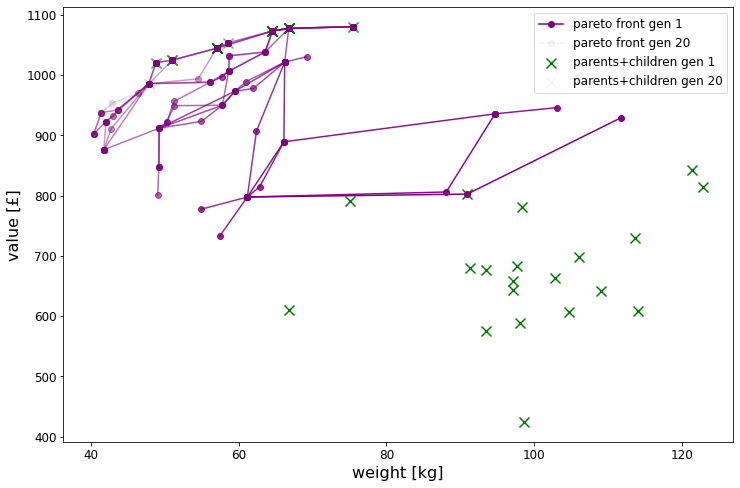

In [502]:
n_generations = 20
parents_compete = True
selector = 'pareto_naive' # 'single_objective_optimisation'
display_pareto_front = True
seed = 1

population_all_pareto = knapsack_genetic_algorithm(n_generations, seed=seed, selector=selector, 
                                                   exact_n_selection=True,
                                                   parents_compete=parents_compete,
                                                   display_pareto_front=display_pareto_front
                                                  )

plt.title('Pareto Optimisation')
ax = plt.gca()
x_lim = ax.get_xlim()
y_lim = ax.get_ylim()

In [ ]:
selector = 'single_objective_optimisation'

population_all_soh = knapsack_genetic_algorithm(n_generations, seed=seed, selector=selector, 
                                                exact_n_selection=True, 
                                                parents_compete=parents_compete,
                                                display_pareto_front=display_pareto_front
                                               )

plt.xlim(*x_lim)
plt.ylim(*y_lim)
plt.title('Single Objective Optimisation: value/weight')

In [ ]:
# Evaluating objective values for populations (weight, value) as well as single objective heuristic: value/weight 

for idx_indv, indv in population_all_pareto.items():
    for objective in objectives:
        if objective not in indv:
            knapsack_objective(indv, objective, packages)
                    
    indv['value_weight_ratio'] = knapsack_to_soh(indv)
    
for idx_indv, indv in population_all_soh.items():
    for objective in objectives:
        if objective not in indv:
            knapsack_objective(indv, objective, packages)
                    
    indv['value_weight_ratio'] = knapsack_to_soh(indv)

In [ ]:
# visualising all individuals of both methods 


def jitter(x, loc=1., scale=0.005):
    return x * np.random.normal(loc, scale)

alpha = 0.2
size = 10
jitter_factor = 0.0


print(f'The pareto run generated {len(population_all_pareto):,} individuals and the SOH generated {len(population_all_soh):,}')

indvs_pareto_weights = np.array([knapsacks['weight'] for idx_knapsack, knapsacks in population_all_pareto.items()])
indvs_pareto_values  = np.array([knapsacks['value']  for idx_knapsack, knapsacks in population_all_pareto.items()])
plt.scatter(jitter(indvs_pareto_weights, scale = jitter_factor), jitter(indvs_pareto_values, scale = jitter_factor), 
            s=size, alpha=alpha, color='green', label='Pareto Optimisation individuals', marker=None, linewidth=4)


indvs_soh_weights = np.array([knapsacks['weight'] for idx_knapsack, knapsacks in population_all_soh.items()])
indvs_soh_values  = np.array([knapsacks['value']  for idx_knapsack, knapsacks in population_all_soh.items()])
plt.scatter(jitter(indvs_soh_weights, scale = jitter_factor), jitter(indvs_soh_values, scale = jitter_factor),
            s=size, alpha=alpha, color='red', label='Single Objective Optimisation individuals', marker='s', linewidth=4)


plot_pareto_front(population_all_pareto, color='green', label='Pareto Optimisation Pareto Front')
plot_pareto_front(population_all_soh, color='red', label='Single Objective Optimisation Pareto Front', marker='-s')

indv_ = single_objective_selector(population_all_pareto, n_select=1)
key = list(indv_.keys())[0]
plt.plot(indv_[key]['weight'], indv_[key]['value'], '*', markersize=20, color='green', alpha=1, label='Pareto Optimisation max Value/Weight')

indv_ = single_objective_selector(population_all_soh, n_select=1)
key = list(indv_.keys())[0]
plt.plot(indv_[key]['weight'], indv_[key]['value'], '*', markersize=20, color='red', alpha=0.6, label='Single Objective Optimisation max Value/Weight')


plt.xlabel('weight [kg]')
plt.ylabel('value [£]')
plt.title(f'Individuals of all {n_generations} generations')

plt.legend(fontsize=10)
# plt.xlim(*x_lim)
# plt.ylim(*y_lim)
pass

In [ ]:
import pandas as pd

top = 4

print(f'Duplication of Individuals in Single Objective (showing top {top})')
pd.Series([tuple(sorted(knapsack['packages'])) for idx_knapsack, knapsack in population_all_soh.items()]).value_counts().head(top)

In [ ]:
print(f'Duplication of Individuals in Pareto Optimisation (showing top {top})')
pd.Series([tuple(sorted(knapsack['packages'])) for idx_knapsack, knapsack in population_all_pareto.items()]).value_counts().head(top)

In [ ]:
# visualising a selected generation

n_generation_examine = -1 # -1 # 'final'

jitter_factor = 0 # 0.001

# ----
if ('final' == n_generation_examine) or (-1 == n_generation_examine):
    n_generation_examine = n_generations - 1
    
assert n_generation_examine < n_generations
    
# indexes of this generation
idx_indvs_pareto = [idx_indv for idx_indv, indv in population_all_pareto.items() if n_generation_examine in population_all_pareto[idx_indv]['generations']]
idx_indvs_soh = [idx_indv for idx_indv, indv in population_all_soh.items() if n_generation_examine in population_all_soh[idx_indv]['generations']]

# population of this generation
population_gen_pareto = {idx_knapsack: knapsack for idx_knapsack, knapsack in population_all_pareto.items() if idx_knapsack in idx_indvs_pareto}
popuation_gen_soh     = {idx_knapsack: knapsack for idx_knapsack, knapsack in population_all_soh.items() if idx_knapsack in idx_indvs_soh}

print(f'In this generation (no. {n_generation_examine + 1})\nthe pareto run had {len(idx_indvs_pareto):,} individuals and the SOH generated {len(idx_indvs_soh):,}')

indvs_pareto_weights = np.array([knapsacks['weight'] for idx_knapsack, knapsacks in population_all_pareto.items() if idx_knapsack in idx_indvs_pareto])
indvs_pareto_values  = np.array([knapsacks['value']  for idx_knapsack, knapsacks in population_all_pareto.items() if idx_knapsack in idx_indvs_pareto])
plt.scatter(jitter(indvs_pareto_weights, scale = jitter_factor), jitter(indvs_pareto_values, scale = jitter_factor), 
            s=size, alpha=alpha, color='green', label='Pareto Optimisation', marker=None, linewidth=4)



indvs_soh_weights = np.array([knapsacks['weight'] for idx_knapsack, knapsacks in population_all_soh.items() if idx_knapsack in idx_indvs_soh])
indvs_soh_values  = np.array([knapsacks['value']  for idx_knapsack, knapsacks in population_all_soh.items() if idx_knapsack in idx_indvs_soh])
plt.scatter(jitter(indvs_soh_weights, scale = jitter_factor), jitter(indvs_soh_values, scale = jitter_factor),
            s=size, alpha=alpha, color='red', label='Value/Weight', marker='s', linewidth=4)


plot_pareto_front(population_gen_pareto, color='green', label='Pareto Optimisation Pareto Front')
plot_pareto_front(popuation_gen_soh, color='red', label='Single Objective Optimisation Pareto Front', marker='-s')

indv_ = single_objective_selector(population_gen_pareto, n_select=1)
key = list(indv_.keys())[0]
plt.plot(indv_[key]['weight'], indv_[key]['value'], '*', markersize=20, color='green', alpha=1, label='Pareto Optimisation max Value/Weight')

indv_ = single_objective_selector(popuation_gen_soh, n_select=1)
key = list(indv_.keys())[0]
plt.plot(indv_[key]['weight'], indv_[key]['value'], '*', markersize=20, color='red', alpha=0.6, label='Single Objective Optimisation max Value/Weight')


plt.legend(fontsize=10)  #(bbox_to_anchor=(1., 1))
plt.xlabel('weight [kg]')
plt.ylabel('value [£]')
plt.title(f'Individuals of generation {n_generation_examine} ')

# plt.xlim(*x_lim)
# plt.ylim(*y_lim)
pass

In [ ]:
top = 4

print(f'Duplication of Individuals in Single Objective Optimisation in generation {n_generation_examine} (showing top {top})')
pd.Series([tuple(sorted(knapsack['packages'])) for idx_knapsack, knapsack in popuation_gen_soh.items()]).value_counts().head(top)

In [ ]:
print(f'Duplication of Individuals in Pareto Optimisation in generation {n_generation_examine} (showing top {top})')
pd.Series([tuple(sorted(knapsack['packages'])) for idx_knapsack, knapsack in population_gen_pareto.items()]).value_counts().head(top)

# Decision Making

Role of domain expert. 

You might be that expert!  (annecdotal related video: The Expert)

Explore vs. Exploit

# Resources

* `DEAP`

* `pymoo` ([site](http://pymoo.org/), [github](https://github.com/msu-coinlab/pymoo/tree/6bad624cc70d12856b47c17cf0f9908a1b3653c5), [arxiv](https://arxiv.org/pdf/2002.04504.pdf) ). comment: no spea2

# Appendix: Visualising Decision Space

In [ ]:
# visulalising the decision space

width = 0.4
alpha = 0.6

package_idxs, package_counts = np.unique([package_idx for idx_indv, indv in population_all_pareto.items() for package_idx in indv['packages']], return_counts=True)
package_counts_pareto = {package_idx: package_count for package_idx, package_count in zip(package_idxs, package_counts)}

package_idxs, package_counts = np.unique([package_idx for idx_indv, indv in population_all_soh.items() for package_idx in indv['packages']], return_counts=True)
package_counts_soh = {package_idx: package_count for package_idx, package_count in zip(package_idxs, package_counts)}


package_idxs = np.array(list(package_counts_pareto.keys()))

plt.figure(figsize=(16,5))

plt.subplot(1, 2, 1)

plt.bar(package_idxs - width/2, package_counts_pareto.values(), color='green', width=width, alpha=alpha)
plt.bar(package_idxs + width/2, package_counts_soh.values() , color='red', width=width, alpha=alpha)
plt.xticks(np.arange(len(package_idxs)), package_idxs)

plt.xlabel('package index')
plt.ylabel('counts')

# ----

plt.subplot(1, 2, 2)
plt.scatter([packages[idx_package]['weight'] for idx_package in packages],
            [packages[idx_package]['value'] for idx_package in packages],
            color = 'purple', alpha=0.04
           )


for idx_package, package in packages.items():
    fontsize_ = MEDIUM_SIZE
    plt.annotate(f'{idx_package:02.0f}', xy=(package['weight'], package['value']), fontsize=fontsize_)
    
plt.xlabel('weight [kg]')
plt.ylabel('value [£]')
plt.title('Packages')


pass